In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np 

In [2]:
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=4, stride=2)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 2)
        self.attention = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)  # Add the maximum value pooling
        x = torch.relu(self.conv2(x))
        x = self.max_pool(x)  # Add the maximum value pooling again
        # Calculate the attention weights
        attention_weights = torch.softmax(self.attention(x.mean(dim=(2, 3))), dim=1)
        # Weighting average features using attention weights
        x = (x * attention_weights.unsqueeze(2).unsqueeze(3)).sum(dim=(2, 3))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class EnsembleCNN(nn.Module):
    def __init__(self, num_networks=2):
        super(EnsembleCNN, self).__init__()
        self.num_networks = num_networks
        self.networks = nn.ModuleList([CNNWithAttention() for _ in range(num_networks)])

    def forward(self, x):
        predictions = torch.zeros(x.size(0), 2).to(x.device)  # Initialize the prediction result
        for i in range(self.num_networks):
            predictions += self.networks[i](x)  # Accumulate the prediction results for each network
        predictions /= self.num_networks  # Take the average to get the final prediction result
        return predictions

In [3]:
# Load the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Suppose the dataset is deposited in the data _ dir directory and contains two subfolders, malignant and benign, with images of malignant and benign tumors, respectively
train_dir = "archive/test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dir = "archive/train"
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Divide between the training set and the test sets

# Create the data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create the data loader
model = EnsembleCNN(num_networks=3)


In [74]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_conv_output(conv_output):
    # Move the channel dimension to the back side
    img_array = conv_output.squeeze(0).permute(1, 2, 0).numpy()
    
    # display image
    plt.imshow(img_array)
    plt.axis('off')  # The axes are not displayed
    plt.show()


In [75]:
for i, (inputs, labels) in enumerate(train_loader):
    break

In [76]:
inputs[0:1].shape

torch.Size([1, 3, 128, 128])

In [77]:
model = torch.load("83.01%_model.pth")
model.eval()

EnsembleCNN(
  (networks): ModuleList(
    (0): CNNWithAttention(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=2, bias=True)
      (attention): Linear(in_features=64, out_features=1, bias=True)
    )
    (1): CNNWithAttention(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=2, bias=True)
      (attention): Linear(in_features=64, out_features=1, bias=True)
 

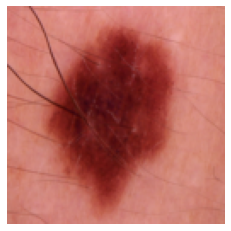

In [78]:
visualize_conv_output(inputs[0:1])

In [79]:
conv1_result = model.networks[0].conv1(inputs[0:1])

In [108]:
def visualize_image(image_tensor, ax=None):
    if ax is None:
        plt.imshow(image_tensor.squeeze(0).numpy(), cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image_tensor.squeeze(0).numpy(), cmap='gray')
        ax.axis('off')

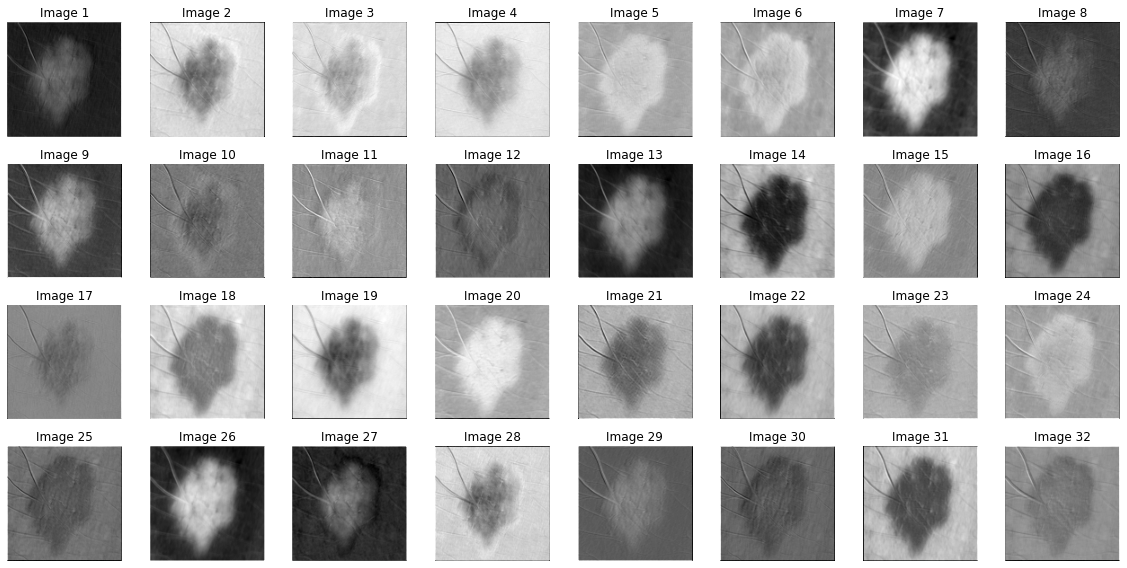

In [109]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))

# Perverse through 32 images and draw them
for i, ax in enumerate(axes.flatten()):
    image_tensor = conv1_result[0][i:i+1].detach()  # Obtain the tensor data for the i th image
    visualize_image(image_tensor, ax)  # Draw the image using the above function
    ax.set_title(f'Image {i + 1}')  # Set the subgraph header

plt.tight_layout()  # Adjust the subgraph layout to prevent overlap
plt.show()

In [112]:
relu1_result = torch.relu(conv1_result)

In [138]:
relu1_result.shape

torch.Size([1, 32, 128, 128])

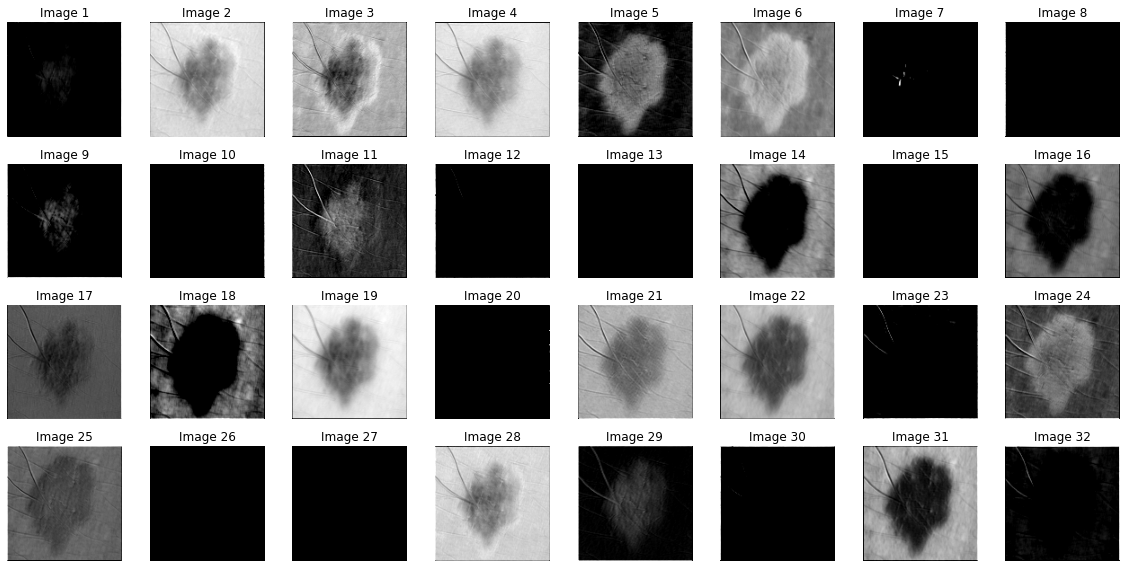

In [113]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))

# Perverse through 32 images and draw them
for i, ax in enumerate(axes.flatten()):
    image_tensor = relu1_result[0][i:i+1].detach()  # Obtain the tensor data for the i th image
    visualize_image(image_tensor, ax)  # Draw the image using the above function
    ax.set_title(f'Image {i + 1}')  # Set the subgraph header

plt.tight_layout()  # Adjust the subgraph layout to prevent overlap
plt.show()

In [120]:
max_pool1 = model.networks[0].max_pool(relu1_result)

In [121]:
max_pool1.shape

torch.Size([1, 32, 63, 63])

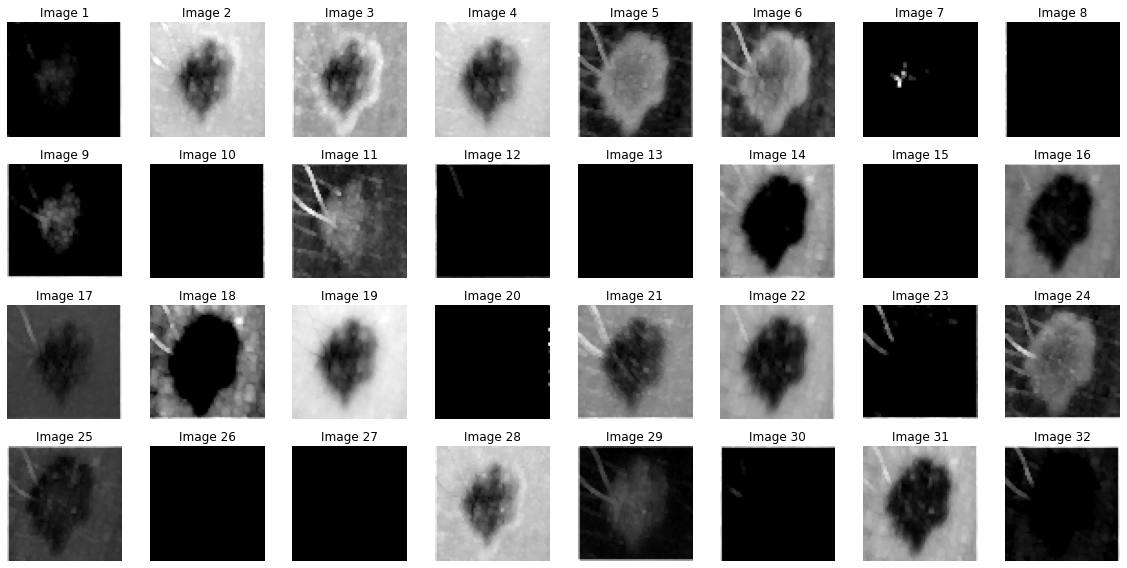

In [122]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))

# Perverse through 32 images and draw them
for i, ax in enumerate(axes.flatten()):
    image_tensor = max_pool1[0][i:i+1].detach()  # Obtain the tensor data for the i th image
    visualize_image(image_tensor, ax)  # Draw the image using the above function
    ax.set_title(f'Image {i + 1}')  # Set the subgraph header

plt.tight_layout()  # Adjust the subgraph layout to prevent overlap
plt.show()

In [128]:
conv2_result = torch.relu(model.networks[0].conv2(max_pool1))

In [137]:
conv2_result.shape

torch.Size([1, 64, 63, 63])

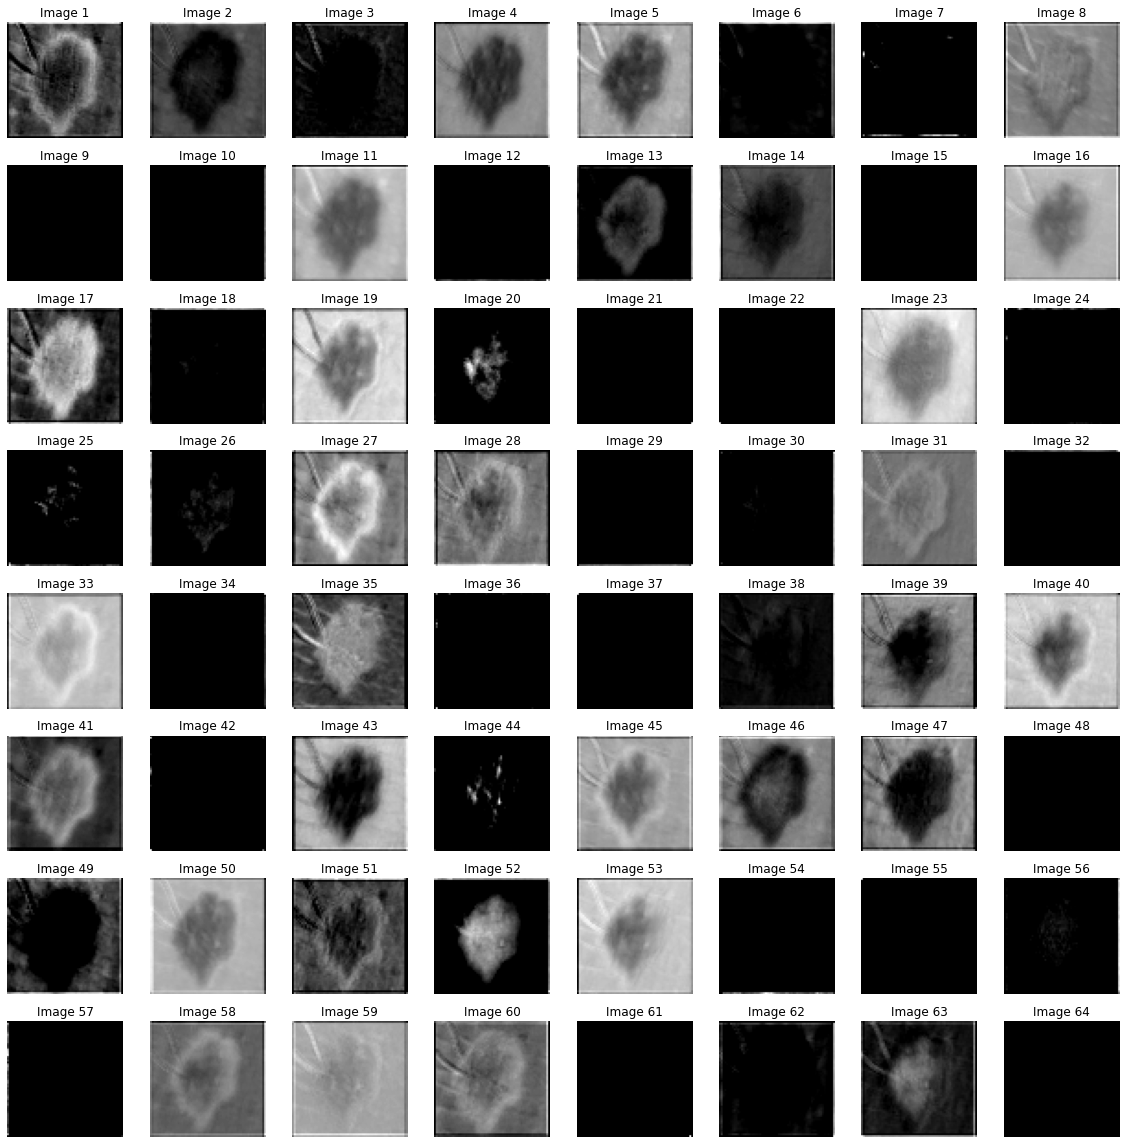

In [130]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))

# Perverse through 32 images and draw them
for i, ax in enumerate(axes.flatten()):
    image_tensor = conv2_result[0][i:i+1].detach()  # Obtain the tensor data for the i th image
    visualize_image(image_tensor, ax)  # Draw the image using the above function
    ax.set_title(f'Image {i + 1}')  # Set the subgraph header

plt.tight_layout()  # Adjust the subgraph layout to prevent overlap
plt.show()

In [133]:
max_pool2 = model.networks[0].max_pool(conv2_result)

In [136]:
max_pool2.shape

torch.Size([1, 64, 30, 30])

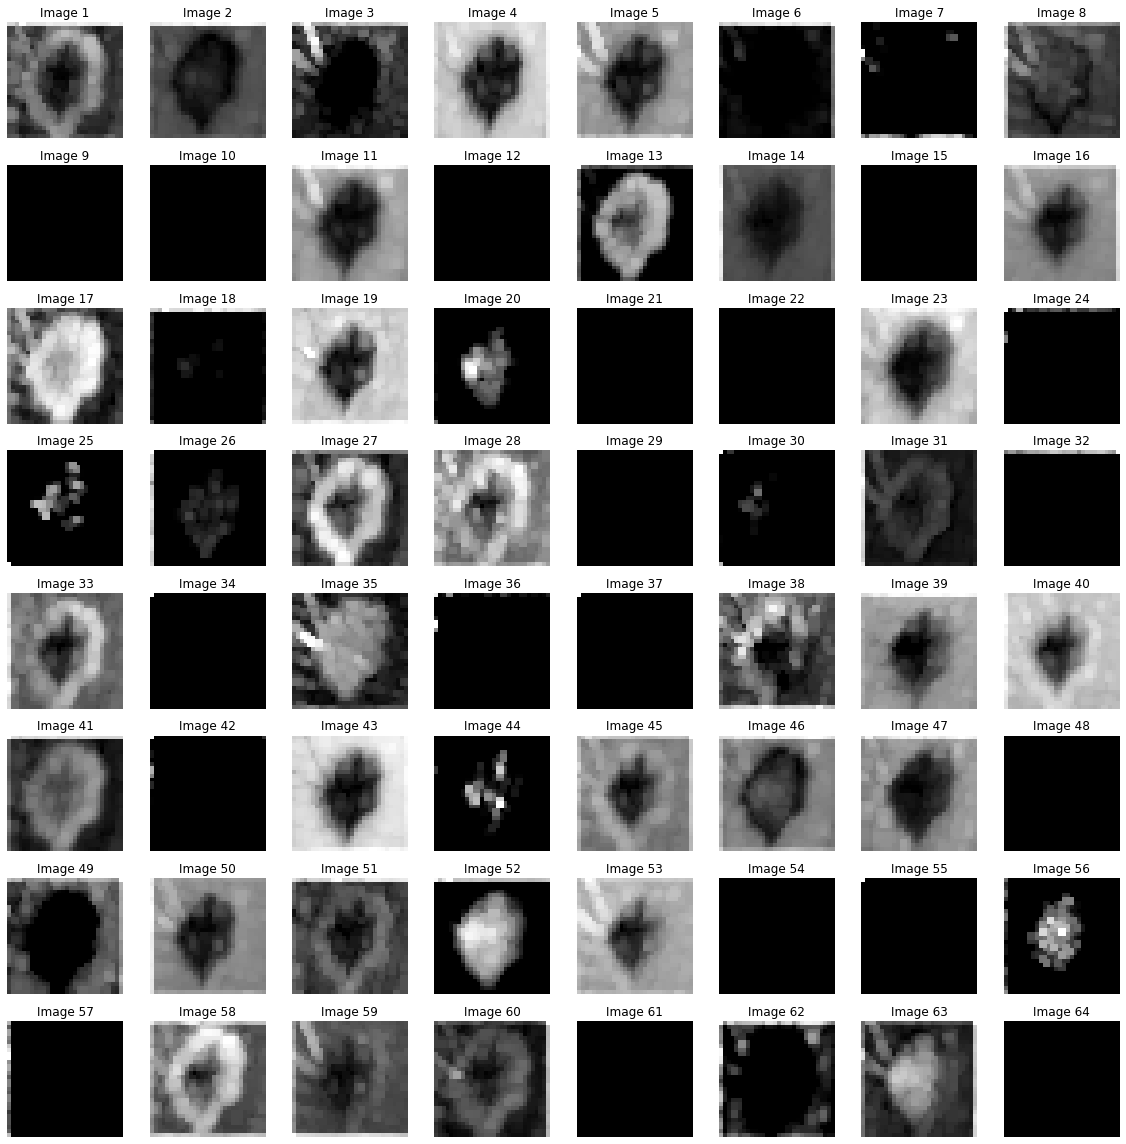

In [135]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))

# Perverse through 32 images and draw them
for i, ax in enumerate(axes.flatten()):
    image_tensor = max_pool2[0][i:i+1].detach()  # Obtain the tensor data for the i th image
    visualize_image(image_tensor, ax)  # Draw the image using the above function
    ax.set_title(f'Image {i + 1}')  # Set the subgraph header

plt.tight_layout()  # Adjust the subgraph layout to prevent overlap
plt.show()

In [156]:
attention_weights = torch.softmax(model.networks[0].attention(max_pool2.mean(dim=(2, 3))), dim=1)

In [157]:
attention_result= (max_pool2 * attention_weights.unsqueeze(2).unsqueeze(3)).sum(dim=(2, 3))

In [158]:
attention_result.shape

torch.Size([1, 64])

In [159]:
attention_result = attention_result.view(attention_result.size(0), -1)

In [160]:
attention_result.shape

torch.Size([1, 64])

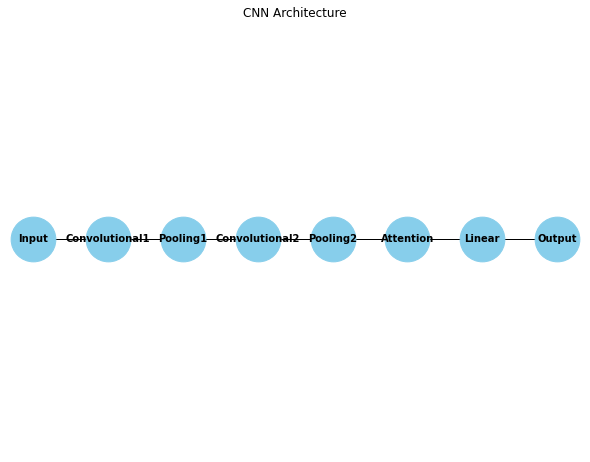

In [185]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add a node (layer)
layers = ['Input', 'Convolutional1', 'Convolutional2', 'Pooling1','Pooling2', 'Attention','Linear' ,'Output']
G.add_nodes_from(layers)

# Add edge (connection relationship)
edges = [('Input', 'Convolutional1'), 
         ('Convolutional1', 'Pooling1'), 
         ('Pooling1', 'Convolutional2'), 
         ('Convolutional2', 'Pooling2'), 
         ('Pooling2', 'Attention'),
        ('Attention', 'Linear'),
        ('Linear', 'Output')]
G.add_edges_from(edges)

# Define the node location
pos = {
    'Input': (0, 0),
    'Convolutional1': (1, 0),
    'Pooling1': (2, 0),
    'Convolutional2': (3, 0),
    'Pooling2': (4, 0),
    'Attention': (5, 0),
    'Linear': (6, 0),
    'Output': (7, 0)
}

# Draw images
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', arrows=False)
plt.title("CNN Architecture")
plt.show()

